In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import pickle
import torch.nn as nn
from torch.autograd import Variable


## Create dataset

In [3]:
# loading relevancy data

path = 'C:/Users/User/OneDrive - NTNU/NTNU/Prosjekt oppgave NLP/dataset/CORD-19/'
file = 'relevance_data.csv'

label_data = pd.read_csv(path + file)
label_data.head()

,Unnamed: 0,topic_id,round_id,cord_uid,relevancy
0,0,1,4.5,005b2j4b,2
1,1,1,4.0,00fmeepz,1
2,2,1,0.5,010vptx3,2
3,3,1,2.5,0194oljo,1
4,4,1,4.0,021q9884,1


In [4]:
# loading topics data

path = 'C:/Users/User/OneDrive - NTNU/NTNU/Prosjekt oppgave NLP/dataset/CORD-19/'
file = 'topics.csv'

topics = pd.read_csv(path + file)
topics.head()

,query_id,query,question,narrative
0,1,coronavirus origin,what is the origin of COVID-19,seeking range of information about the SARS-Co...
1,2,coronavirus response to weather changes,how does the coronavirus respond to changes in...,seeking range of information about the SARS-Co...
2,3,coronavirus immunity,will SARS-CoV2 infected people develop immunit...,seeking studies of immunity developed due to i...
3,4,how do people die from the coronavirus,what causes death from Covid-19?,Studies looking at mechanisms of death from Co...
4,5,animal models of COVID-19,what drugs have been active against SARS-CoV o...,Papers that describe the results of testing d...


In [5]:
len(label_data)

69318

In [6]:
# available models: ['bert-base-uncased', "allenai/scibert_scivocab_uncased", "gsarti/covidbert-nli"]

def normalize_tensor(tensor):
    tensor_normed = []
    norm = torch.norm(tensor)
    if norm>0:
        tensor_normed = tensor/norm
    else:
        tensor_normed = tensor
    return tensor_normed

def get_tesors(row, topic_field, doc_field, model):
    topic_path = "C:/Users/User/Documents/NTNU/NLP/CORD-19/topic_embeddings/"
    doc_path = "C:/Users/User/Documents/NTNU/NLP/CORD-19/Embeddings/786/"
    doc_id = row["cord_uid"]
    topic_id = row["topic_id"]
    topic_tensor = []
    doc_tensor = []
    
    doc_embedding_file = doc_path + doc_id + ".txt"
    try:
        with open(doc_embedding_file, "rb") as fp:   # Unpickling
            doc_embedding = pickle.load(fp)
    except:
        return [[0]], [[0]]
        
    doc_tensor = doc_embedding["models"][model][doc_field]
            
    topic_embedding_file = topic_path + str(topic_id) + ".txt"
    with open(topic_embedding_file, "rb") as fp:   # Unpickling
        topic_embedding = pickle.load(fp)
        
    topic_tensor =  topic_embedding["models"][model][topic_field]
    
    topic_tensor = normalize_tensor(topic_tensor)
    doc_tensor = normalize_tensor(doc_tensor)
    
    return topic_tensor, doc_tensor
    

In [7]:
def join_tensors(tensor_a,tensor_b):
    n = len(tensor_a)
    m = len(tensor_b)
    c = torch.empty(n + m)
    c[0:n] = tensor_a
    c[n:(n+m)] = tensor_b
    return c

In [8]:
def isNaN(num):
    return num != num

In [8]:
num = 2000 # max: 69318
x_dataset = torch.empty(num, 768*2)
y_dataset = torch.empty(num)
miss = 0
i = 0
for idx, row in label_data.iterrows():
    if idx < num:
        a, b = get_tesors(row, "query", "title", "gsarti/covidbert-nli")
        if len(a[0]) != 1:
            c = join_tensors(a[0],b[0])
            x_dataset[i] = c
        
            y_dataset[i] = row["relevancy"]
            i+=1
        else:
            miss +=1
print(miss)

KeyboardInterrupt: 

In [ ]:
x_dataset = x_dataset[0:(num-miss)]
y_dataset = y_dataset[0:(num-miss)]

In [ ]:
dat = torch.cat((x_dataset, y_dataset.unsqueeze(1)), 1)

In [ ]:
dat[1][768*2]

In [ ]:
print(len(y_dataset))
print(len(x_dataset))

In [ ]:
# Hyper Parameters 
input_size = 768*2
num_classes = 3
num_epochs = 5
batch_size = 1000
learning_rate = 0.003

In [ ]:
# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=dat, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dat, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
train_loader

In [ ]:
model = LogisticRegression(input_size, num_classes)

# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Training the Model
for epoch in range(num_epochs):
    for i, (X_y) in enumerate(train_loader):
        
        y = X_y[:,768*2]
        #print(y)
        X = X_y[:,0:(768*2)].tolist()
        #print(X)
        #print(list(X.size()))
        #print(len(y))
        y = y.int()
        #print(list(y.size()))
        #print(len(y))
        y =  torch.LongTensor(y.tolist())
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(torch.tensor(X))
        loss = criterion(outputs, y)
        #print(loss)
        #print(model)
        loss.backward()

        optimizer.step()
        
        if (i+1) % 100 == 0:
            #print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
            #       % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
            print(epoch)
            print(loss)



In [ ]:
# Test the Model
correct = 0
total = 0
for X_y in test_loader:
    y = X_y[:,768*2]
    y = y.int()
    y =  torch.LongTensor(y.tolist())
    #print(y)
    X = X_y[:,0:(768*2)].tolist()
    X = torch.tensor(X)
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum()
    
print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
y_dataset.int().tolist().count(0)/len(y_dataset)

In [ ]:
??model

In [ ]:
for i, x in enumerate (x_dataset):
    if i < 10:
        print(i)
        print(len(x))
        p = model(x)
        print(p)
        print(y_dataset[i])

In [ ]:


import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable


In [ ]:

# Hyper Parameters 
input_size = 784
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [ ]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='.', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=False)

test_dataset = dsets.MNIST(root='.', 
                           train=False, 
                           transform=transforms.ToTensor())

In [ ]:
img_tensor, label = train_dataset[0]
print(img_tensor)
print(label)

In [ ]:
# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:


# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out



In [ ]:
for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        print(list(dat.size()))
        print(images)
        print(labels)
        print(i)

In [ ]:
model = LogisticRegression(input_size, num_classes)

# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        #print(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(images[0])
            print(list(images.size()))
            print(list(labels.size()))
            #print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
             #      % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

# Test the Model
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

In [32]:
num = 30000 # max: 69318
x_dataset = torch.empty(num, 768)
y_dataset = torch.empty(num)
miss = 0
i = 0
for idx, row in label_data.iterrows():
    if idx < num:
        a, b = get_tesors(row, "query", "title", "gsarti/covidbert-nli")
        if len(a[0]) != 1:
            c = (a[0]*b[0])
            x_dataset[i] = c
        
            y_dataset[i] = row["relevancy"]
            i+=1
        else:
            miss +=1
        if idx % 1000 == 0:
            print(idx)
print(miss)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
1150


In [33]:
x_dataset = x_dataset[0:(num-miss)]
y_dataset = y_dataset[0:(num-miss)]

In [34]:
dat = torch.cat((x_dataset, y_dataset.unsqueeze(1)), 1)

In [78]:
# Hyper Parameters 
input_size = 768
num_classes = 3
num_epochs = 1000
batch_size = 1000
learning_rate = 0.01

In [79]:
# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=dat, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dat, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [80]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [88]:
model = LogisticRegression(input_size, num_classes)

# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

loss_list = []
# Training the Model
for epoch in range(num_epochs):
    for i, (X_y) in enumerate(train_loader):
        
        y = X_y[:,768]
        #print(y)
        X = X_y[:,0:(768)]#.tolist()
        
        #print(X)
        #print(list(X.size()))
        #print(len(y))
        y = y.int()
        #print(list(y.size()))
        #print(len(y))
        y =  torch.LongTensor(y.tolist())
        #print(y)
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(torch.tensor(X))
        loss = criterion(outputs, y)
        #print(loss)
        #print(model)
        loss.backward()

        optimizer.step()
        loss_list.append(loss)
        
        if ((i) % 20 == 0) and (epoch % 10 == 0):
            #print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
            #       % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
            print("epoch: ",  epoch, " loss: ", loss)


C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:  0  loss:  tensor(1.1004, grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(0.9349, grad_fn=<NllLossBackward>)
epoch:  10  loss:  tensor(0.8711, grad_fn=<NllLossBackward>)
epoch:  10  loss:  tensor(0.8813, grad_fn=<NllLossBackward>)
epoch:  20  loss:  tensor(0.8509, grad_fn=<NllLossBackward>)
epoch:  20  loss:  tensor(0.8443, grad_fn=<NllLossBackward>)
epoch:  30  loss:  tensor(0.8143, grad_fn=<NllLossBackward>)
epoch:  30  loss:  tensor(0.8354, grad_fn=<NllLossBackward>)
epoch:  40  loss:  tensor(0.8215, grad_fn=<NllLossBackward>)
epoch:  40  loss:  tensor(0.8146, grad_fn=<NllLossBackward>)
epoch:  50  loss:  tensor(0.8251, grad_fn=<NllLossBackward>)
epoch:  50  loss:  tensor(0.7941, grad_fn=<NllLossBackward>)
epoch:  60  loss:  tensor(0.8431, grad_fn=<NllLossBackward>)
epoch:  60  loss:  tensor(0.8286, grad_fn=<NllLossBackward>)
epoch:  70  loss:  tensor(0.8107, grad_fn=<NllLossBackward>)
epoch:  70  loss:  tensor(0.8509, grad_fn=<NllLossBackward>)
epoch:  80  loss:  tensor(

epoch:  660  loss:  tensor(0.7735, grad_fn=<NllLossBackward>)
epoch:  670  loss:  tensor(0.7522, grad_fn=<NllLossBackward>)
epoch:  670  loss:  tensor(0.7325, grad_fn=<NllLossBackward>)
epoch:  680  loss:  tensor(0.7784, grad_fn=<NllLossBackward>)
epoch:  680  loss:  tensor(0.7205, grad_fn=<NllLossBackward>)
epoch:  690  loss:  tensor(0.7695, grad_fn=<NllLossBackward>)
epoch:  690  loss:  tensor(0.7436, grad_fn=<NllLossBackward>)
epoch:  700  loss:  tensor(0.7082, grad_fn=<NllLossBackward>)
epoch:  700  loss:  tensor(0.7337, grad_fn=<NllLossBackward>)
epoch:  710  loss:  tensor(0.7570, grad_fn=<NllLossBackward>)
epoch:  710  loss:  tensor(0.8014, grad_fn=<NllLossBackward>)
epoch:  720  loss:  tensor(0.7442, grad_fn=<NllLossBackward>)
epoch:  720  loss:  tensor(0.7415, grad_fn=<NllLossBackward>)
epoch:  730  loss:  tensor(0.7511, grad_fn=<NllLossBackward>)
epoch:  730  loss:  tensor(0.7460, grad_fn=<NllLossBackward>)
epoch:  740  loss:  tensor(0.7068, grad_fn=<NllLossBackward>)
epoch:  

In [89]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

loss_list = []
# Training the Model
for epoch in range(num_epochs):
    for i, (X_y) in enumerate(train_loader):
        
        y = X_y[:,768]
        #print(y)
        X = X_y[:,0:(768)]#.tolist()
        
        #print(X)
        #print(list(X.size()))
        #print(len(y))
        y = y.int()
        #print(list(y.size()))
        #print(len(y))
        y =  torch.LongTensor(y.tolist())
        #print(y)
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(torch.tensor(X))
        loss = criterion(outputs, y)
        #print(loss)
        #print(model)
        loss.backward()

        optimizer.step()
        loss_list.append(loss)
        
        if ((i) % 20 == 0) and (epoch % 10 == 0):
            #print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
            #       % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
            print("epoch: ",  epoch, " loss: ", loss)

C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:  0  loss:  tensor(0.6967, grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(0.7091, grad_fn=<NllLossBackward>)
epoch:  10  loss:  tensor(0.7450, grad_fn=<NllLossBackward>)
epoch:  10  loss:  tensor(0.7240, grad_fn=<NllLossBackward>)
epoch:  20  loss:  tensor(0.7550, grad_fn=<NllLossBackward>)
epoch:  20  loss:  tensor(0.7457, grad_fn=<NllLossBackward>)
epoch:  30  loss:  tensor(0.7701, grad_fn=<NllLossBackward>)
epoch:  30  loss:  tensor(0.7332, grad_fn=<NllLossBackward>)
epoch:  40  loss:  tensor(0.7464, grad_fn=<NllLossBackward>)
epoch:  40  loss:  tensor(0.7245, grad_fn=<NllLossBackward>)
epoch:  50  loss:  tensor(0.7182, grad_fn=<NllLossBackward>)
epoch:  50  loss:  tensor(0.7123, grad_fn=<NllLossBackward>)
epoch:  60  loss:  tensor(0.7168, grad_fn=<NllLossBackward>)
epoch:  60  loss:  tensor(0.7164, grad_fn=<NllLossBackward>)
epoch:  70  loss:  tensor(0.7724, grad_fn=<NllLossBackward>)
epoch:  70  loss:  tensor(0.7141, grad_fn=<NllLossBackward>)
epoch:  80  loss:  tensor(

epoch:  660  loss:  tensor(0.7510, grad_fn=<NllLossBackward>)
epoch:  670  loss:  tensor(0.7311, grad_fn=<NllLossBackward>)
epoch:  670  loss:  tensor(0.7479, grad_fn=<NllLossBackward>)
epoch:  680  loss:  tensor(0.7509, grad_fn=<NllLossBackward>)
epoch:  680  loss:  tensor(0.7127, grad_fn=<NllLossBackward>)
epoch:  690  loss:  tensor(0.7368, grad_fn=<NllLossBackward>)
epoch:  690  loss:  tensor(0.7405, grad_fn=<NllLossBackward>)
epoch:  700  loss:  tensor(0.7556, grad_fn=<NllLossBackward>)
epoch:  700  loss:  tensor(0.7532, grad_fn=<NllLossBackward>)
epoch:  710  loss:  tensor(0.7305, grad_fn=<NllLossBackward>)
epoch:  710  loss:  tensor(0.7321, grad_fn=<NllLossBackward>)
epoch:  720  loss:  tensor(0.7160, grad_fn=<NllLossBackward>)
epoch:  720  loss:  tensor(0.6950, grad_fn=<NllLossBackward>)
epoch:  730  loss:  tensor(0.7482, grad_fn=<NllLossBackward>)
epoch:  730  loss:  tensor(0.7336, grad_fn=<NllLossBackward>)
epoch:  740  loss:  tensor(0.7655, grad_fn=<NllLossBackward>)
epoch:  

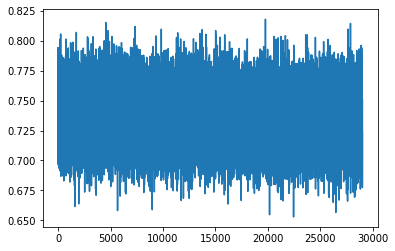

In [90]:
plt.plot(loss_list)

In [91]:
# Test the Model
correct = 0
total = 0
for X_y in test_loader:
    y = X_y[:,768]
    y = y.int()
    y =  torch.LongTensor(y.tolist())
    #print(y)
    X = X_y[:,0:(768)].tolist()
    X = torch.tensor(X)
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum()
    
print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the model on the 10000 test images: 69 %


In [92]:
y_dataset.int().tolist().count(0)/len(y_dataset)

0.6600693240901213

In [86]:
model[0]

TypeError: 'LogisticRegression' object is not subscriptable

In [ ]:
num = 30000 # max: 69318
x_dataset = torch.empty(num, 768)
y_dataset = torch.empty(num)
miss = 0
i = 0
for idx, row in label_data.iterrows():
    if idx < num:
        a, b = get_tesors(row, "question", "title", "gsarti/covidbert-nli")
        if len(a[0]) != 1:
            c = (a[0]*b[0])
            x_dataset[i] = c
            rel = 0
            if row["relevancy"]>0.01:
                rel = 1
            y_dataset[i] = rel
            i+=1
        else:
            miss +=1
        if idx % 1000 == 0:
            print(idx)
print(miss)

In [ ]:
x_dataset = x_dataset[0:(num-miss)]
y_dataset = y_dataset[0:(num-miss)]

In [93]:
a = torch.tensor([[1,2],[3,4],[5,6],[7,8],[9,10]])

In [94]:
a[[1,2,4]]

tensor([[ 3,  4],
        [ 5,  6],
        [ 9, 10]])